In [1]:

%pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
%pip install -q opencv-python-headless tqdm

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import kagglehub

import torch
from torch.utils.data import Dataset, DataLoader

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
path = kagglehub.dataset_download("soumicksarker/ipn-hand-dataset")
print(path)
df = pd.read_csv(os.path.join(path, "metadata.csv"))
df.head()

C:\Users\zxjia\.cache\kagglehub\datasets\soumicksarker\ipn-hand-dataset\versions\7


,Video Name,Frames,Sex,Hand,Background,Illumination,People in Scene,Background Motion,Set,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,1CM1_4_R__229,3751,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1CM1_4_R__230,3684,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1CM1_4_R__231,3747,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1CM1_4_R__232,3858,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1CM42_11_R__205,3686,M,Right,Plain,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(df.columns)


Index(['Video Name', 'Frames', 'Sex', 'Hand', 'Background', 'Illumination',
       'People in Scene', 'Background Motion', 'Set', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')


Using video directory: C:\Users\zxjia\.cache\kagglehub\datasets\soumicksarker\ipn-hand-dataset\versions\7\videos/videos
Sample files: ['1CM1_1_R__217.avi', '1CM1_1_R__218.avi', '1CM1_1_R__219.avi', '1CM1_1_R__220.avi', '1CM1_2_R__221.avi']
Testing video: C:\Users\zxjia\.cache\kagglehub\datasets\soumicksarker\ipn-hand-dataset\versions\7\videos/videos\1CM1_1_R__218.avi


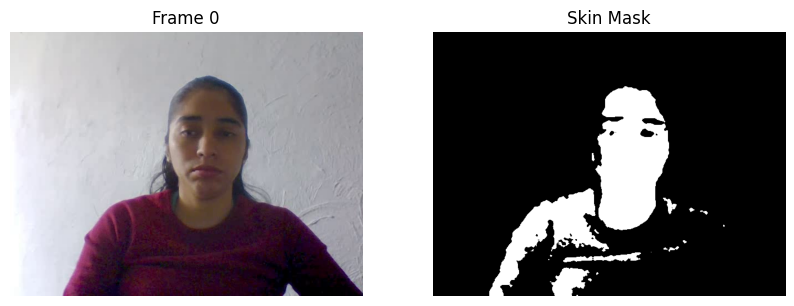

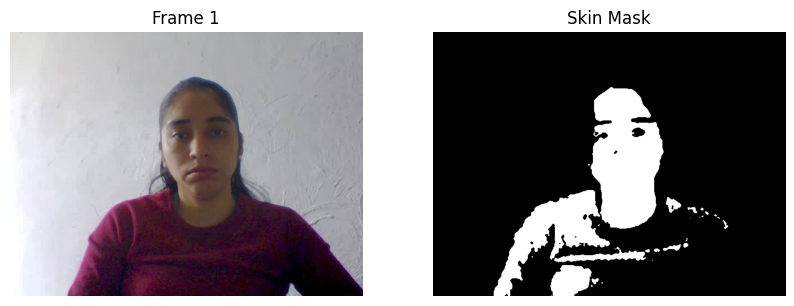

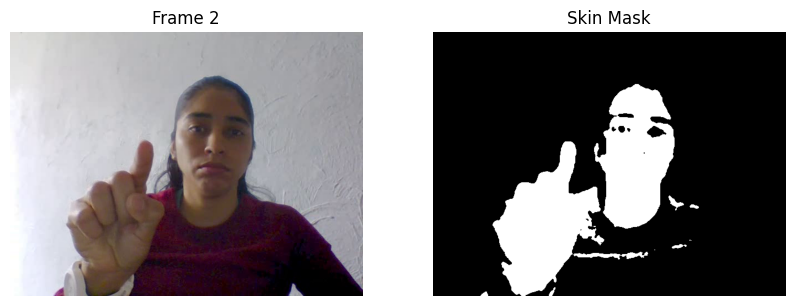

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

video_dir = os.path.join(path, "videos/videos")
output_dir = os.path.join(path, "hand_dataset")
os.makedirs(output_dir, exist_ok=True)

print("Using video directory:", video_dir)
print("Sample files:", os.listdir(video_dir)[:5])

video_file = os.listdir(video_dir)[1]
video_path = os.path.join(video_dir, video_file)

print("Testing video:", video_path)

cap = cv2.VideoCapture(video_path)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_indices = [total_frames//4, total_frames//2, 3*total_frames//4]

frames = []
for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if ret:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


cap.release()

def skin_mask_bgr(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    lower = np.array([0, 40, 60])
    upper = np.array([25, 255, 255])
    mask1 = cv2.inRange(hsv, lower, upper)

    lower2 = np.array([160, 40, 60])
    upper2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower2, upper2)

    mask = cv2.bitwise_or(mask1, mask2)
    mask = cv2.medianBlur(mask, 5)
    return mask

for i, f in enumerate(frames):
    mask = skin_mask_bgr(f)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(f)
    plt.title(f"Frame {i}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Skin Mask")
    plt.axis("off")

    plt.show()


In [5]:
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Sample frames evenly across the video
    frame_indices = [frame_count//4, frame_count//2, 3*frame_count//4]

    hand_id = 0  # counter for cropped hands

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mask = skin_mask_bgr(frame_rgb)

        # Find contours on the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            # Filter by size (remove tiny blobs)
            if cv2.contourArea(cnt) < 1000:
                continue

            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = w / h
            area = cv2.contourArea(cnt)

            if area < 1000 or area > 15000:  # filter tiny or huge blobs
                continue
            if aspect_ratio < 0.3 or aspect_ratio > 1.5:  # roughly rectangular
                continue
            if y < frame.shape[0] // 3:
                continue

            hand_crop = frame_rgb[y:y+h, x:x+w]

            save_path = os.path.join(output_dir, f"{video_file}_hand_{hand_id}.png")
            cv2.imwrite(save_path, cv2.cvtColor(hand_crop, cv2.COLOR_RGB2BGR))
            hand_id += 1

    cap.release()
    print(f"Processed {video_file}, saved {hand_id} hand crops.")


Processed 1CM1_1_R__217.avi, saved 2 hand crops.
Processed 1CM1_1_R__218.avi, saved 4 hand crops.
Processed 1CM1_1_R__219.avi, saved 2 hand crops.
Processed 1CM1_1_R__220.avi, saved 0 hand crops.
Processed 1CM1_2_R__221.avi, saved 1 hand crops.
Processed 1CM1_2_R__222.avi, saved 0 hand crops.
Processed 1CM1_2_R__223.avi, saved 1 hand crops.
Processed 1CM1_2_R__224.avi, saved 2 hand crops.
Processed 1CM1_3_R__225.avi, saved 9 hand crops.
Processed 1CM1_3_R__226.avi, saved 7 hand crops.
Processed 1CM1_3_R__227.avi, saved 10 hand crops.
Processed 1CM1_3_R__228.avi, saved 3 hand crops.
Processed 1CM1_4_R__229.avi, saved 8 hand crops.
Processed 1CM1_4_R__230.avi, saved 7 hand crops.
Processed 1CM1_4_R__231.avi, saved 4 hand crops.
Processed 1CM1_4_R__232.avi, saved 5 hand crops.
Processed 1CM42_11_R__205.avi, saved 3 hand crops.
Processed 1CM42_11_R__206.avi, saved 3 hand crops.
Processed 1CM42_11_R__207.avi, saved 4 hand crops.
Processed 1CM42_11_R__208.avi, saved 4 hand crops.
Processed 1

Total hand crops: 1144


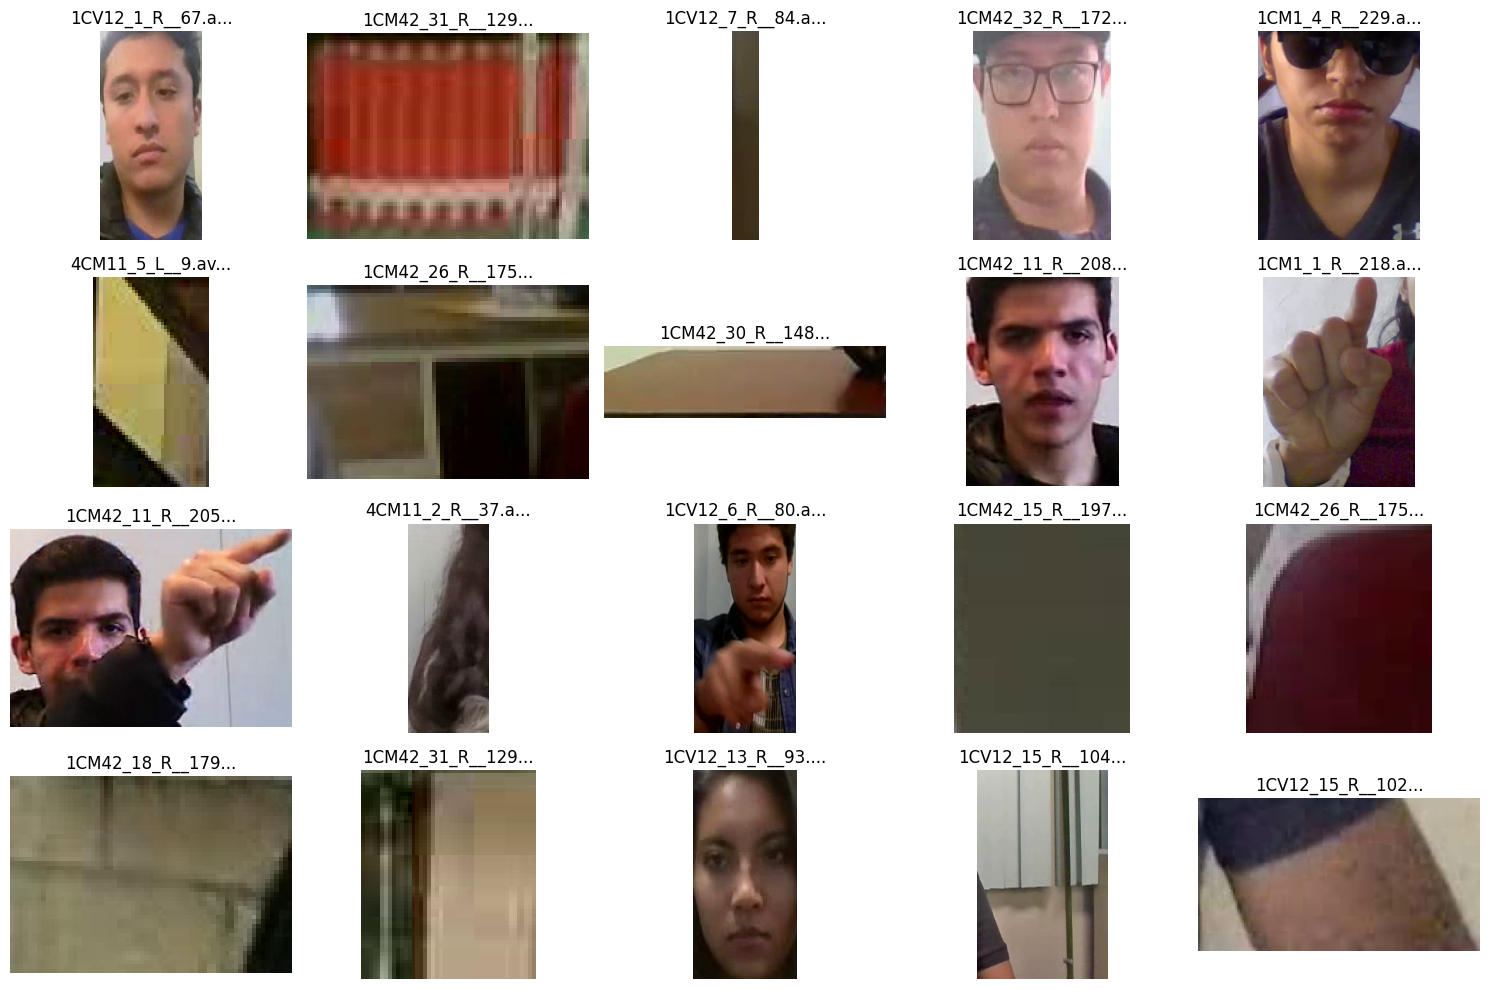

In [6]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Get all saved hand crops
saved_files = os.listdir(output_dir)
print(f"Total hand crops: {len(saved_files)}")

# Pick a random sample of 20 images
sample_files = random.sample(saved_files, min(20, len(saved_files)))

# Set up grid for display
rows = 4
cols = 5
plt.figure(figsize=(15, 10))

for i, f in enumerate(sample_files):
    img_path = os.path.join(output_dir, f)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img_rgb)
    plt.title(f"{f[:15]}...")  # truncate long filenames
    plt.axis("off")

plt.tight_layout()
plt.show()
